In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
base_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw'
train_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/train'
test_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/test'
val_dir = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/val'

train_dir_neg = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/train/train_neg'
train_dir_pos = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/train/train_pos'

test_dir_neg = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/test/test_neg'
test_dir_pos = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/test/test_pos'

val_dir_neg = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/val/val_neg'
val_dir_pos = '/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/collected_raw/val/val_pos'

In [4]:
num_neg_train = len(os.listdir(train_dir_neg))
num_neg_test = len(os.listdir(test_dir_neg))
num_neg_val = len(os.listdir(val_dir_neg))

num_pos_train = len(os.listdir(train_dir_pos))
num_pos_test = len(os.listdir(test_dir_pos))
num_pos_val = len(os.listdir(val_dir_pos))

In [5]:
print("Total Negative train Images",num_neg_train)
print("Total Negative test Images",num_neg_test)
print("Total Negative val Images",num_neg_val)
print("--")
print("Total Positive train Images",num_pos_train)
print("Total Positive test Images",num_pos_test)
print("Total Positive val Images",num_pos_val)
print("--")

total_train = num_neg_train + num_pos_train
total_validation = num_neg_val + num_pos_val
total_test = num_neg_test + num_pos_test

print("--")
print("Total Images",total_train + total_validation + total_test)
print("Total Training Images",total_train)
print("--")
print("Total Validation Images",total_validation)
print("--")
print("Total Testing Images",total_test)

Total Negative train Images 251
Total Negative test Images 54
Total Negative val Images 54
--
Total Positive train Images 582
Total Positive test Images 124
Total Positive val Images 124
--
--
Total Images 1189
Total Training Images 833
--
Total Validation Images 178
--
Total Testing Images 178


In [6]:
IMG_SHAPE  = 224
batch_size = 32

In [7]:
image_gen_train = ImageDataGenerator(rescale = 1./255)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
directory = train_dir,
shuffle= True,
target_size = (IMG_SHAPE,IMG_SHAPE),
class_mode = 'binary')

image_generator_validation = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator_validation.flow_from_directory(batch_size=batch_size,
directory=val_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')

image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
directory=test_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')

Found 833 images belonging to 2 classes.
Found 178 images belonging to 2 classes.
Found 178 images belonging to 2 classes.


In [8]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [9]:
for layer in pre_trained_model.layers:
  print(layer.name)
  layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [10]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [11]:
model = tf.keras.Model(pre_trained_model.input, x)

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [13]:
vgg_classifier = model.fit(train_data_gen,
steps_per_epoch=(total_train//batch_size),
epochs = 10,
validation_data=val_data_gen,
validation_steps=(total_validation//batch_size),
batch_size = batch_size,
verbose = 1)

Epoch 1/10
26/26 [==============================] - 23s 410ms/step - loss: 0.4776 - acc: 0.8152 - val_loss: 0.4757 - val_acc: 0.7625
Epoch 2/10
26/26 [==============================] - 11s 404ms/step - loss: 0.1987 - acc: 0.9176 - val_loss: 0.4983 - val_acc: 0.7437
Epoch 3/10
26/26 [==============================] - 10s 365ms/step - loss: 0.1219 - acc: 0.9488 - val_loss: 0.4859 - val_acc: 0.7625
Epoch 4/10
26/26 [==============================] - 10s 364ms/step - loss: 0.0847 - acc: 0.9675 - val_loss: 0.3006 - val_acc: 0.8500
Epoch 5/10
26/26 [==============================] - 10s 370ms/step - loss: 0.0781 - acc: 0.9688 - val_loss: 0.3620 - val_acc: 0.8250
Epoch 6/10
26/26 [==============================] - 10s 368ms/step - loss: 0.0469 - acc: 0.9800 - val_loss: 0.3396 - val_acc: 0.8562
Epoch 7/10
26/26 [==============================] - 10s 364ms/step - loss: 0.0405 - acc: 0.9913 - val_loss: 0.2076 - val_acc: 0.9000
Epoch 8/10
26/26 [==============================] - 10s 364ms/step - 

In [14]:
result = model.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",result)

6/6 [==============================] - 97s 19s/step - loss: 0.5567 - acc: 0.8034
test_loss, test accuracy [0.5567311644554138, 0.8033707737922668]


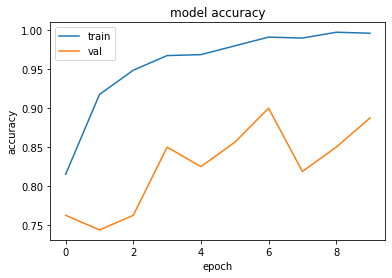

In [15]:
from matplotlib import pyplot as plt
plt.plot(vgg_classifier.history['acc'])
plt.plot(vgg_classifier.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

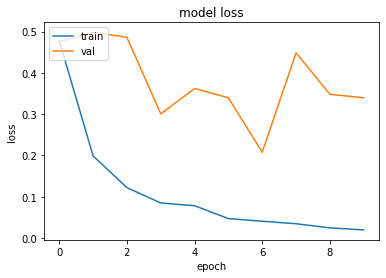

In [16]:
from matplotlib import pyplot as plt
plt.plot(vgg_classifier.history['loss'])
plt.plot(vgg_classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
model_json = model.to_json()
with open("/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/VGG_Stair_Detector.json", "w") as json_file:
  json_file.write(model_json)
  model.save("/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/VGG_Stair_Detector.h5")
  print("Saved model to disk")
  model.save_weights("/content/drive/MyDrive/UGent/Sem1/MachinaalLeren/sprint3/VGG_Stair_Weights.h5")

Saved model to disk
